# Person / No-Person Detection (FP32 → FP16 → INT8)

Colab-ready end-to-end notebook.

## 1. Environment Setup

In [ ]:

# from google.colab import drive
# drive.mount('/content/drive')

import os, random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
#!unzip /content/person-detection-dataset.zip

## 2. Dataset Configuration

In [ ]:

DATASET_PATH = "/content/person-detection-dataset"
IMG_SIZE = (96, 96)
BATCH_SIZE = 32
SEED = 42


## 3. Visualize Sample Images

Detected classes: ['NoPerson.class', 'Person.class']


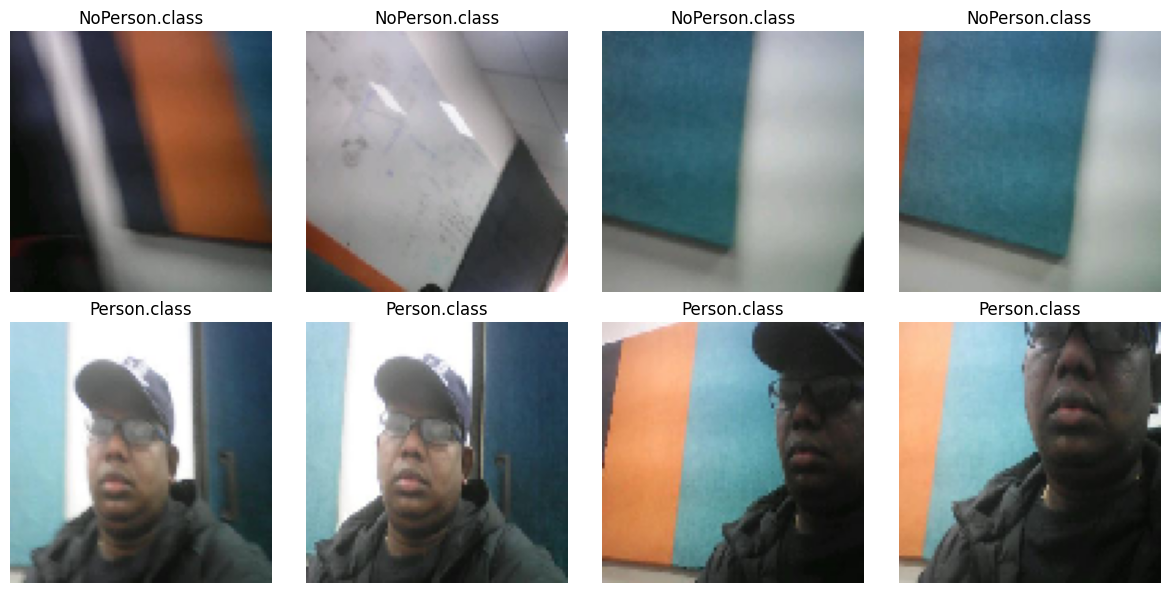

In [ ]:

from tensorflow.keras.preprocessing import image

class_names = sorted([
    d for d in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, d))
])

assert len(class_names) == 2
print("Detected classes:", class_names)

plt.figure(figsize=(12,6))
for row, class_name in enumerate(class_names):
    imgs = random.sample(os.listdir(os.path.join(DATASET_PATH, class_name)), 4)
    for col, img_name in enumerate(imgs):
        img = image.load_img(os.path.join(DATASET_PATH, class_name, img_name), target_size=IMG_SIZE)
        plt.subplot(2,4,row*4 + col + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")
plt.tight_layout()
plt.show()


## 4. Data Generators

In [ ]:

train_test_gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_val_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_val_gen.flow_from_directory(
    DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", subset="training", shuffle=True, seed=SEED)

val_generator = train_val_gen.flow_from_directory(
    DATASET_PATH, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode="binary", subset="validation", shuffle=False, seed=SEED)

test_generator = train_test_gen.flow_from_directory(
    DATASET_PATH, target_size=IMG_SIZE, batch_size=1,
    class_mode="binary", subset="validation", shuffle=False, seed=SEED)


Found 87 images belonging to 2 classes.
Found 21 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


## 5. CNN Model

In [ ]:

model = keras.Sequential([
    keras.layers.Conv2D(32, 3, activation="relu", input_shape=(96,96,3)),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(128, 3, activation="relu"),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])


# model = keras.Sequential([
#     keras.layers.Input(shape=(96, 96, 3)),

#     # Block 1
#     keras.layers.Conv2D(8, (3,3), padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),
#     keras.layers.MaxPooling2D((2,2)),

#     # Block 2
#     keras.layers.Conv2D(16, (3,3), padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),
#     keras.layers.MaxPooling2D((2,2)),

#     # Block 3
#     keras.layers.Conv2D(24, (3,3), padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),
#     keras.layers.MaxPooling2D((2,2)),

#     # Block 4
#     keras.layers.Conv2D(32, (3,3), padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),
#     keras.layers.MaxPooling2D((2,2)),

#     # Block 5
#     keras.layers.Conv2D(40, (3,3), padding="same"),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),

#     # Head
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(40),
#     keras.layers.BatchNormalization(),
#     keras.layers.ReLU(),

#     keras.layers.Dense(1, activation="sigmoid")

# ])


# This is the final model suitable for deployment
# model = keras.Sequential([
#     keras.layers.Input((96,96,3)),

#     keras.layers.Conv2D(8, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),

#     keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),

#     keras.layers.Conv2D(24, 3, padding="same", activation="relu"),
#     keras.layers.MaxPooling2D(),

#     keras.layers.Conv2D(32, 3, padding="same", activation="relu"),

#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(1, activation="sigmoid")
# ])


model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 96, 96, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 48, 48, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 24, 24, 24)     │         3,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 12, 12, 32)     │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,849 (46.29 KB)

 Trainable params: 11,849 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Training

In [ ]:

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "person_no_person.keras", monitor="val_accuracy",
    save_best_only=True, verbose=1)

earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_generator, validation_data=val_generator,
    epochs=30, callbacks=[checkpoint_cb, earlystop_cb])


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.5405 - loss: 0.6924
Epoch 1: val_accuracy improved from -inf to 0.57143, saving model to person_no_person.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 997ms/step - accuracy: 0.5491 - loss: 0.6920 - val_accuracy: 0.5714 - val_loss: 0.6860
Epoch 2/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6562 - loss: 0.6785
Epoch 2: val_accuracy did not improve from 0.57143
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5785 - loss: 0.6860 - val_accuracy: 0.5714 - val_loss: 0.6818
Epoch 3/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.5625 - loss: 0.6828
Epoch 3: val_accuracy did not improve from 0.57143
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5590 - loss: 0.6832 - val_accuracy: 0.5714 - val_loss: 0.6795
Epoch 4/30
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5312 - loss: 0.6912
Epoch 4: val_accuracy did not improve from 0.57143
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5599 - loss: 0.6817 - val_accuracy: 0.

## 7. FP32 Evaluation

In [ ]:

test_loss, test_acc = model.evaluate(test_generator)
print("FP32 accuracy:", test_acc)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7296 - loss: 0.3720  
FP32 accuracy: 0.800000011920929


## 8. Quantization & Comparison

In [ ]:

def get_file_size_mb(p): return os.path.getsize(p)/(1024*1024)

model.save("fp32.keras")
float_size = get_file_size_mb("fp32.keras")

# FP16
conv_fp16 = tf.lite.TFLiteConverter.from_keras_model(model)
conv_fp16.optimizations = [tf.lite.Optimize.DEFAULT]
conv_fp16.target_spec.supported_types = [tf.float16]
fp16 = conv_fp16.convert()
open("fp16.tflite","wb").write(fp16)
fp16_size = get_file_size_mb("fp16.tflite")

# INT8
def rep_ds():
    for x,_ in test_generator:
        yield [x]
        break

# =========================
# INT8 Quantization (Nicla / OpenMV safe)
# =========================
conv_int8 = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable full INT8 optimization
conv_int8.optimizations = [tf.lite.Optimize.DEFAULT]

# Representative dataset (IMPORTANT: small + static)
conv_int8.representative_dataset = rep_ds

# Force ONLY built-in INT8 ops (critical for OpenMV)
conv_int8.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8
]

# Force static input/output types
conv_int8.inference_input_type = tf.uint8
conv_int8.inference_output_type = tf.uint8

# Disable experimental features that increase memory
conv_int8.experimental_new_converter = True
conv_int8.experimental_enable_resource_variables = False

# Convert
int8 = conv_int8.convert()

# Save model
with open("int8.tflite", "wb") as f:
    f.write(int8)

int8_size = get_file_size_mb("int8.tflite")
print(f"INT8 model size: {int8_size:.2f} MB")


Saved artifact at '/tmp/tmpswltcx4w'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_68')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132124421720784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421720976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421719632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421720592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421719248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421719824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421720208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421720016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421724624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132124421720400: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved artifact 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
import tensorflow as tf

interpreter = tf.lite.Interpreter(model_path="int8.tflite")
interpreter.allocate_tensors()
print("INT8 model loaded successfully")


INT8 model loaded successfully


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


## 9. FP16 Evaluation

In [ ]:
# =========================
# FP16 Evaluation (TFLite)
# =========================
interpreter_fp16 = tf.lite.Interpreter(model_path="fp16.tflite")
interpreter_fp16.allocate_tensors()

input_details = interpreter_fp16.get_input_details()
output_details = interpreter_fp16.get_output_details()

correct = 0
total = 0
MAX_SAMPLES = 1000   # keep same as INT8 for fair comparison

for images, labels in tqdm(test_generator, total=MAX_SAMPLES, desc="FP16 eval"):
    # FP16 model expects float32 input
    interpreter_fp16.set_tensor(
        input_details[0]["index"],
        images.astype(np.float32)
    )
    interpreter_fp16.invoke()

    output = interpreter_fp16.get_tensor(output_details[0]["index"])
    pred = int(output[0][0] > 0.5)   # sigmoid threshold

    correct += (pred == int(labels[0]))
    total += 1

    if total >= MAX_SAMPLES:
        break

fp16_acc = correct / total
print(f"FP16 accuracy: {fp16_acc:.4f}")


FP16 eval: 100%|█████████▉| 999/1000 [00:01<00:00, 715.79it/s]

FP16 accuracy: 0.8000





## 10. INT8 Evaluation

In [ ]:

interp = tf.lite.Interpreter("int8.tflite")
interp.allocate_tensors()
inp = interp.get_input_details()[0]
out = interp.get_output_details()[0]

correct=0; total=0
for imgs, labels in tqdm(test_generator, total=1000):
    scale, zp = inp['quantization']
    q = (imgs/scale+zp).astype(np.uint8)
    interp.set_tensor(inp['index'], q)
    interp.invoke()
    pred = interp.get_tensor(out['index'])[0][0] > 128
    correct += (int(pred)==int(labels[0]))
    total+=1
    if total>=1000: break

int8_acc = correct/total
print("INT8 accuracy:", int8_acc)


100%|█████████▉| 999/1000 [00:01<00:00, 657.95it/s]

INT8 accuracy: 0.4


## 11. Final Report

In [ ]:

pd.DataFrame({
    "Model":["FP32","FP16","INT8"],
    "Accuracy":[test_acc,fp16_acc,int8_acc],
    "Size (MB)":[float_size,fp16_size,int8_size]
})


,Model,Accuracy,Size (MB)
0,FP32,0.8,0.178976
1,FP16,0.8,0.027637
2,INT8,0.4,0.018181
